In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import torch

In [2]:
sys.path.append('/kaggle/input/transolver/Transolver/PDE-Solving-StandardBenchmark')

In [3]:
dataset_paths = [
    str(path) for path in
    pathlib.Path('/kaggle/input/static-data/processed_data').glob("*")
]

In [4]:
len(dataset_paths)

49

In [5]:
xr_tmp = xr.open_dataset(dataset_paths[1])
xr_tmp['CONC'].attrs['MIN_LATS']

array([54.9994, 55.0087, 55.0976, 55.0096, 55.0364, 54.941 , 55.0666,
       54.6561, 55.0642, 54.9707])

In [6]:
np.array(xr.open_dataset(dataset_paths[1])['CONC'][:, 0, 0, :, :]).shape


(18, 251, 201)

In [7]:
xr.open_dataset(dataset_paths[1])

<xarray.Dataset> Size: 36MB
Dimensions:      (Time: 18, species: 1, releases: 10, south_north: 251,
                  west_east: 201)
Coordinates:
  * Time         (Time) |S15 270B b'20240908_202000' ... b'20240909_020000'
  * species      (species) <U4 16B 'PM25'
  * releases     (releases) int32 40B 0 1 2 3 4 5 6 7 8 9
  * south_north  (south_north) float64 2kB 54.5 54.5 54.51 ... 55.39 55.4 55.4
  * west_east    (west_east) float64 2kB 82.3 82.3 82.31 ... 83.64 83.64 83.65
Data variables:
    CONC         (Time, species, releases, south_north, west_east) float32 36MB ...

In [8]:
# ('MIN_LATS', 'MIN_LONGS', 'MAX_LATS', 'MAX_LONGS')

In [9]:
def parse_data(dataset_paths):
    data = []
    source_coordinats = []
    for p in tqdm(dataset_paths):
        for source in range(10):
            subset = xr.open_dataset(p)['CONC'][:, 0, source, :, :]
            source_MIN_LATS = xr.open_dataset(p)['CONC'].attrs['MIN_LATS'][source]
            source_MIN_LONGS = xr.open_dataset(p)['CONC'].attrs['MIN_LONGS'][source]
            source_MAX_LATS = xr.open_dataset(p)['CONC'].attrs['MAX_LATS'][source]
            source_MAX_LONGS = xr.open_dataset(p)['CONC'].attrs['MAX_LONGS'][source]
            subset = np.array(subset)
            source_coordinats.append([
                source,
                source_MIN_LATS,
                source_MIN_LONGS,
                source_MAX_LATS,
                source_MAX_LONGS
                ])
            data.append(subset)
    return np.array(data), np.array(source_coordinats)

In [10]:
data, source_coordinats = parse_data(dataset_paths)

100%|██████████| 49/49 [01:25<00:00,  1.74s/it]


In [11]:
data = np.transpose(data, (0, 2, 3, 1))

In [12]:
T_in = 18
T = 8
# h = 101
r = 2
ntrain = 400
ntest = 90
step = 1
# todo: отнормировать масштаб в интервал от 0 до 1

In [13]:
train_a = data[:ntrain, :, :, :]
train_a_coords = source_coordinats[:ntrain]
train_a = train_a.reshape(train_a.shape[0], -1, train_a.shape[-1])
train_a = torch.from_numpy(train_a)
train_a_coords = torch.from_numpy(train_a_coords)

# train_u = data[:ntrain, :, :, :]
# train_u = train_u.reshape(train_u.shape[0], -1, train_u.shape[-1])
# train_u = torch.from_numpy(train_u)



test_a = data[-ntest:, :, :, :]
test_a_coords = source_coordinats[-ntest:]
test_a = test_a.reshape(test_a.shape[0], -1, test_a.shape[-1])
test_a = torch.from_numpy(test_a)
test_a_coords = torch.from_numpy(test_a_coords)

# test_u = data[-ntest:, :, :, :]
# test_u = test_u.reshape(test_u.shape[0], -1, test_u.shape[-1])
# test_u = torch.from_numpy(test_u)

In [14]:
x = np.linspace(0, 1, 251)
y = np.linspace(0, 1, 201)
x, y = np.meshgrid(x, y)
pos = np.c_[x.ravel(), y.ravel()]
pos = torch.tensor(pos, dtype=torch.float).unsqueeze(0)
pos_train = pos.repeat(ntrain, 1, 1)
pos_test = pos.repeat(ntest, 1, 1)

In [15]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(pos_train, train_a, train_a_coords),
                                           batch_size=8,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(pos_test, test_a, test_a_coords),
                                          batch_size=8,
                                          shuffle=True)

In [16]:
from model.Transolver_Structured_Mesh_2D import Model

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [57]:
tmodel = Model(space_dim=2,
               n_layers=3,
               n_hidden=64,
               n_head=4,
               Time_Input=False,
               mlp_ratio=1,
               fun_dim=17,
               out_dim=1,
               slice_num=64,
               ref=8,
               unified_pos=1,
               H=201,
               W=251).cuda()

In [58]:
optimizer = torch.optim.AdamW(tmodel.parameters())

In [51]:
from utils.testloss import TestLoss

In [59]:
myloss = TestLoss(size_average=False)

In [60]:
# input - conc data
# output - coords of source
# how source coords depends on time
# while predict conc field, it is clear
# how to make good pred if time does not affect coords

# is it classification problem? source is in discrete set

In [61]:
pred.shape

torch.Size([8, 50451, 1])

In [62]:
for epoch in tqdm(range(100)):
    tmodel.train()
    L = 0.0
    for xb, yb, coords in train_loader:
        xb, yb, coords = xb.cuda(), yb.cuda(), coords.cuda()
        pred = tmodel(xb, yb[..., 1:])
        loss = myloss(pred, yb[..., 0].reshape(yb.shape[0], yb.shape[1], 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        L += loss.item()
    print(f"Epoch {epoch:03d}  loss {L/len(train_loader):.6f}")


  1%|          | 1/100 [00:43<1:11:36, 43.39s/it]

Epoch 000  loss 7.887219


  2%|▏         | 2/100 [01:27<1:11:10, 43.58s/it]

Epoch 001  loss 7.713620


  3%|▎         | 3/100 [02:10<1:10:16, 43.47s/it]

Epoch 002  loss 7.522406


  4%|▍         | 4/100 [02:53<1:09:34, 43.48s/it]

Epoch 003  loss 7.310370


  5%|▌         | 5/100 [03:37<1:08:50, 43.48s/it]

Epoch 004  loss 7.112957


  6%|▌         | 6/100 [04:20<1:08:07, 43.49s/it]

Epoch 005  loss 6.897770


  7%|▋         | 7/100 [05:04<1:07:25, 43.50s/it]

Epoch 006  loss 6.674202


  8%|▊         | 8/100 [05:47<1:06:42, 43.51s/it]

Epoch 007  loss 6.508966


  9%|▉         | 9/100 [06:31<1:06:00, 43.52s/it]

Epoch 008  loss 6.344724


 10%|█         | 10/100 [07:15<1:05:16, 43.52s/it]

Epoch 009  loss 6.180146


 11%|█         | 11/100 [07:58<1:04:33, 43.52s/it]

Epoch 010  loss 6.034313


 12%|█▏        | 12/100 [08:42<1:03:49, 43.51s/it]

Epoch 011  loss 5.901525


 13%|█▎        | 13/100 [09:25<1:03:05, 43.52s/it]

Epoch 012  loss 5.774839


 14%|█▍        | 14/100 [10:09<1:02:21, 43.50s/it]

Epoch 013  loss 5.658173


 15%|█▌        | 15/100 [10:52<1:01:37, 43.50s/it]

Epoch 014  loss 5.717180


 16%|█▌        | 16/100 [11:36<1:00:54, 43.51s/it]

Epoch 015  loss 5.506883


 17%|█▋        | 17/100 [12:19<1:00:12, 43.52s/it]

Epoch 016  loss 5.396599


 18%|█▊        | 18/100 [13:03<59:28, 43.52s/it]  

Epoch 017  loss 5.325036


 19%|█▉        | 19/100 [13:46<58:45, 43.52s/it]

Epoch 018  loss 5.289241


 20%|██        | 20/100 [14:30<58:01, 43.52s/it]

Epoch 019  loss 5.223787


 21%|██        | 21/100 [15:13<57:17, 43.51s/it]

Epoch 020  loss 5.122012


 22%|██▏       | 22/100 [15:57<56:33, 43.51s/it]

Epoch 021  loss 5.070278


 23%|██▎       | 23/100 [16:40<55:50, 43.51s/it]

Epoch 022  loss 5.006456


 24%|██▍       | 24/100 [17:24<55:07, 43.51s/it]

Epoch 023  loss 5.059485


 25%|██▌       | 25/100 [18:07<54:24, 43.52s/it]

Epoch 024  loss 4.907758


 26%|██▌       | 26/100 [18:51<53:40, 43.52s/it]

Epoch 025  loss 4.910029


 27%|██▋       | 27/100 [19:34<52:58, 43.54s/it]

Epoch 026  loss 4.814742


 28%|██▊       | 28/100 [20:18<52:14, 43.53s/it]

Epoch 027  loss 4.771627


 29%|██▉       | 29/100 [21:01<51:29, 43.52s/it]

Epoch 028  loss 4.752279


 30%|███       | 30/100 [21:45<50:46, 43.52s/it]

Epoch 029  loss 4.723570


 31%|███       | 31/100 [22:28<50:03, 43.52s/it]

Epoch 030  loss 4.640383


 32%|███▏      | 32/100 [23:12<49:19, 43.52s/it]

Epoch 031  loss 4.609226


 33%|███▎      | 33/100 [23:56<48:37, 43.54s/it]

Epoch 032  loss 4.628686


 34%|███▍      | 34/100 [24:39<47:53, 43.54s/it]

Epoch 033  loss 4.584356


 35%|███▌      | 35/100 [25:23<47:09, 43.53s/it]

Epoch 034  loss 4.554045


 36%|███▌      | 36/100 [26:06<46:26, 43.53s/it]

Epoch 035  loss 4.468598


 37%|███▋      | 37/100 [26:50<45:42, 43.54s/it]

Epoch 036  loss 4.446693


 38%|███▊      | 38/100 [27:33<44:58, 43.53s/it]

Epoch 037  loss 4.415423


 39%|███▉      | 39/100 [28:17<44:15, 43.52s/it]

Epoch 038  loss 4.371035


 40%|████      | 40/100 [29:00<43:31, 43.52s/it]

Epoch 039  loss 4.350719


 41%|████      | 41/100 [29:44<42:47, 43.52s/it]

Epoch 040  loss 4.317860


 42%|████▏     | 42/100 [30:27<42:04, 43.52s/it]

Epoch 041  loss 4.360617


 43%|████▎     | 43/100 [31:11<41:20, 43.53s/it]

Epoch 042  loss 4.264087


 44%|████▍     | 44/100 [31:54<40:37, 43.53s/it]

Epoch 043  loss 4.270124


 45%|████▌     | 45/100 [32:38<39:53, 43.52s/it]

Epoch 044  loss 4.224400


 46%|████▌     | 46/100 [33:21<39:09, 43.51s/it]

Epoch 045  loss 4.310415


 47%|████▋     | 47/100 [34:05<38:26, 43.52s/it]

Epoch 046  loss 4.365522


 48%|████▊     | 48/100 [34:48<37:43, 43.52s/it]

Epoch 047  loss 4.185593


 49%|████▉     | 49/100 [35:32<36:59, 43.52s/it]

Epoch 048  loss 4.127139


 50%|█████     | 50/100 [36:15<36:16, 43.52s/it]

Epoch 049  loss 4.089828


 51%|█████     | 51/100 [36:59<35:32, 43.52s/it]

Epoch 050  loss 4.079934


 52%|█████▏    | 52/100 [37:42<34:48, 43.51s/it]

Epoch 051  loss 4.099335


 53%|█████▎    | 53/100 [38:26<34:05, 43.52s/it]

Epoch 052  loss 4.077162


 54%|█████▍    | 54/100 [39:10<33:22, 43.53s/it]

Epoch 053  loss 4.047840


 55%|█████▌    | 55/100 [39:53<32:38, 43.53s/it]

Epoch 054  loss 3.989964


 56%|█████▌    | 56/100 [40:37<31:55, 43.53s/it]

Epoch 055  loss 4.015154


 57%|█████▋    | 57/100 [41:20<31:11, 43.53s/it]

Epoch 056  loss 4.021383


 58%|█████▊    | 58/100 [42:04<30:28, 43.52s/it]

Epoch 057  loss 4.063873


 59%|█████▉    | 59/100 [42:47<29:44, 43.53s/it]

Epoch 058  loss 3.923792


 60%|██████    | 60/100 [43:31<29:01, 43.54s/it]

Epoch 059  loss 3.914678


 61%|██████    | 61/100 [44:14<28:18, 43.56s/it]

Epoch 060  loss 3.866496


 62%|██████▏   | 62/100 [44:58<27:36, 43.58s/it]

Epoch 061  loss 3.840816


 63%|██████▎   | 63/100 [45:41<26:51, 43.56s/it]

Epoch 062  loss 3.846351


 64%|██████▍   | 64/100 [46:25<26:07, 43.55s/it]

Epoch 063  loss 3.829489


 65%|██████▌   | 65/100 [47:08<25:23, 43.54s/it]

Epoch 064  loss 3.788191


 66%|██████▌   | 66/100 [47:52<24:39, 43.52s/it]

Epoch 065  loss 3.800489


 67%|██████▋   | 67/100 [48:35<23:56, 43.52s/it]

Epoch 066  loss 4.002971


 68%|██████▊   | 68/100 [49:19<23:12, 43.52s/it]

Epoch 067  loss 3.814191


 69%|██████▉   | 69/100 [50:02<22:28, 43.51s/it]

Epoch 068  loss 3.734470


 70%|███████   | 70/100 [50:46<21:45, 43.52s/it]

Epoch 069  loss 3.729889


 71%|███████   | 71/100 [51:30<21:02, 43.52s/it]

Epoch 070  loss 3.685822


 72%|███████▏  | 72/100 [52:13<20:18, 43.52s/it]

Epoch 071  loss 3.650861


 73%|███████▎  | 73/100 [52:57<19:35, 43.52s/it]

Epoch 072  loss 3.691595


 74%|███████▍  | 74/100 [53:40<18:51, 43.52s/it]

Epoch 073  loss 3.667993


 75%|███████▌  | 75/100 [54:24<18:08, 43.52s/it]

Epoch 074  loss 3.650826


 76%|███████▌  | 76/100 [55:07<17:24, 43.53s/it]

Epoch 075  loss 3.597173


 77%|███████▋  | 77/100 [55:51<16:40, 43.52s/it]

Epoch 076  loss 3.555795


 78%|███████▊  | 78/100 [56:34<15:57, 43.52s/it]

Epoch 077  loss 3.586241


 79%|███████▉  | 79/100 [57:18<15:13, 43.52s/it]

Epoch 078  loss 3.779853


 80%|████████  | 80/100 [58:01<14:30, 43.51s/it]

Epoch 079  loss 3.630426


 81%|████████  | 81/100 [58:45<13:46, 43.51s/it]

Epoch 080  loss 3.579984


 82%|████████▏ | 82/100 [59:28<13:03, 43.52s/it]

Epoch 081  loss 3.598012


 83%|████████▎ | 83/100 [1:00:12<12:19, 43.51s/it]

Epoch 082  loss 3.462211


 84%|████████▍ | 84/100 [1:00:55<11:36, 43.52s/it]

Epoch 083  loss 3.458560


 85%|████████▌ | 85/100 [1:01:39<10:52, 43.52s/it]

Epoch 084  loss 3.463603


 86%|████████▌ | 86/100 [1:02:22<10:09, 43.51s/it]

Epoch 085  loss 3.444698


 87%|████████▋ | 87/100 [1:03:06<09:25, 43.51s/it]

Epoch 086  loss 3.414502


 88%|████████▊ | 88/100 [1:03:49<08:42, 43.51s/it]

Epoch 087  loss 3.374997


 89%|████████▉ | 89/100 [1:04:33<07:58, 43.51s/it]

Epoch 088  loss 3.365334


 90%|█████████ | 90/100 [1:05:16<07:15, 43.51s/it]

Epoch 089  loss 3.391059


 91%|█████████ | 91/100 [1:06:00<06:31, 43.50s/it]

Epoch 090  loss 3.357353


 92%|█████████▏| 92/100 [1:06:43<05:48, 43.51s/it]

Epoch 091  loss 3.337451


 93%|█████████▎| 93/100 [1:07:27<05:04, 43.52s/it]

Epoch 092  loss 3.352270


 94%|█████████▍| 94/100 [1:08:10<04:21, 43.51s/it]

Epoch 093  loss 3.335043


 95%|█████████▌| 95/100 [1:08:54<03:37, 43.52s/it]

Epoch 094  loss 3.296880


 96%|█████████▌| 96/100 [1:09:37<02:54, 43.53s/it]

Epoch 095  loss 3.348818


 97%|█████████▋| 97/100 [1:10:21<02:10, 43.52s/it]

Epoch 096  loss 3.277633


 98%|█████████▊| 98/100 [1:11:04<01:27, 43.52s/it]

Epoch 097  loss 3.307254


 99%|█████████▉| 99/100 [1:11:48<00:43, 43.51s/it]

Epoch 098  loss 3.258926


100%|██████████| 100/100 [1:12:31<00:00, 43.52s/it]

Epoch 099  loss 3.641299


In [64]:
len(test_loader)

12

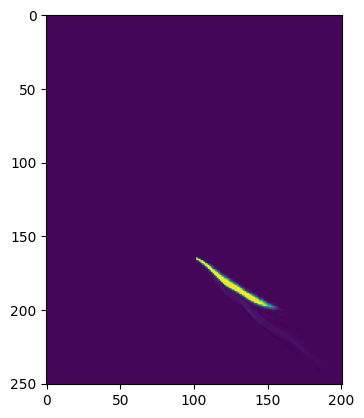

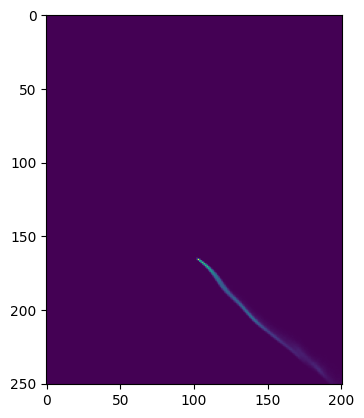

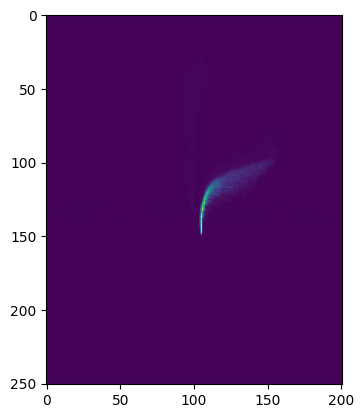

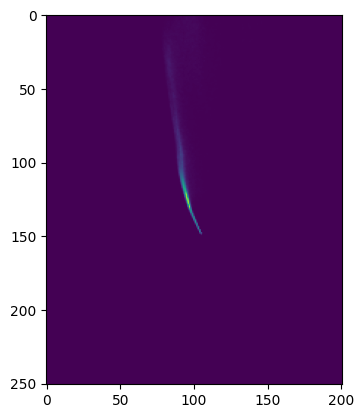

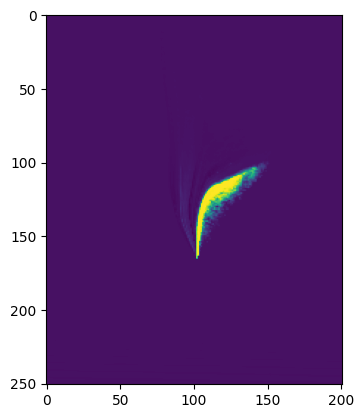

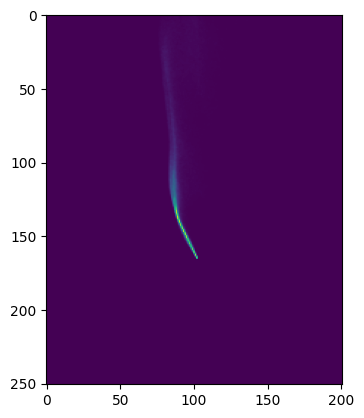

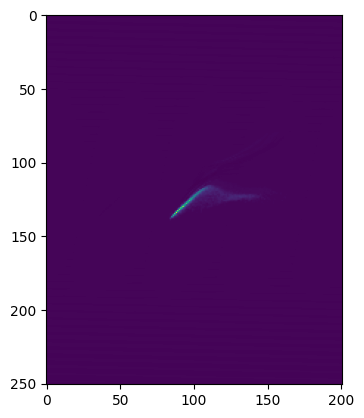

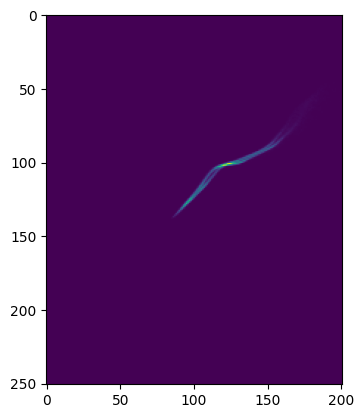

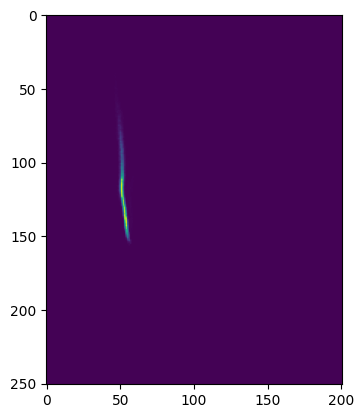

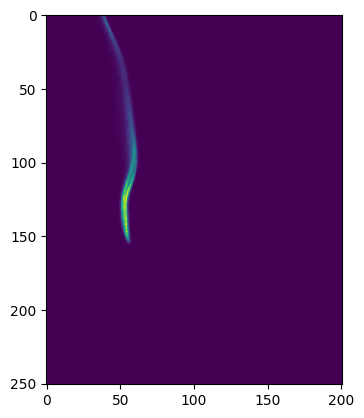

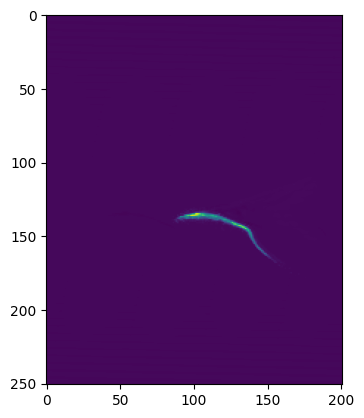

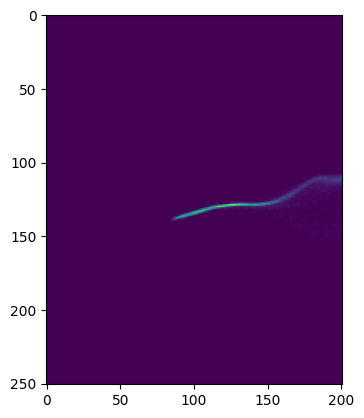

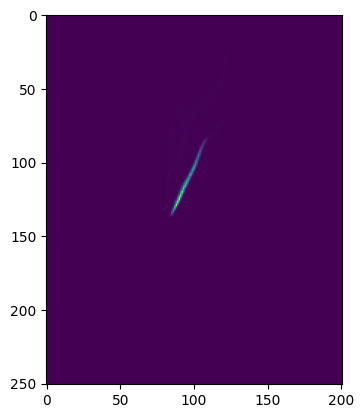

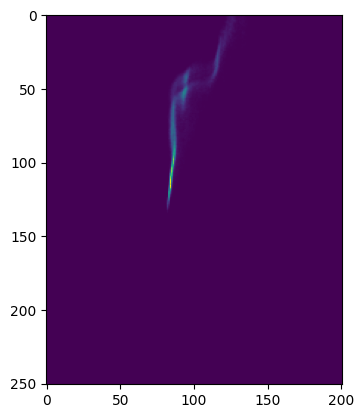

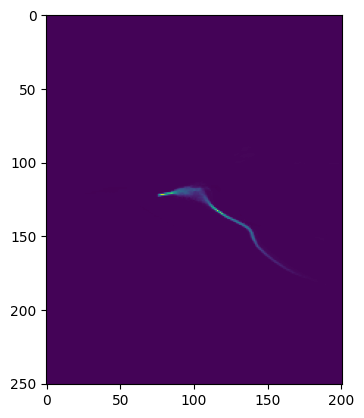

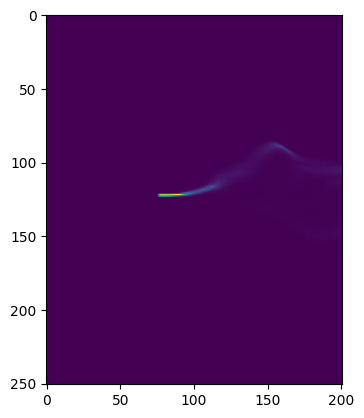

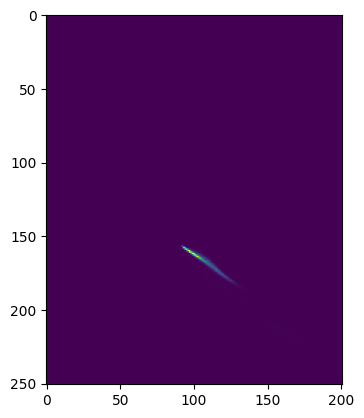

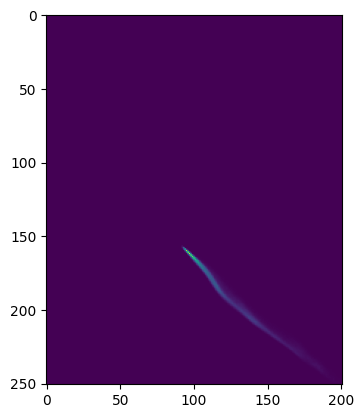

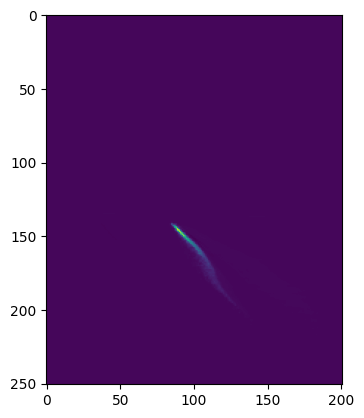

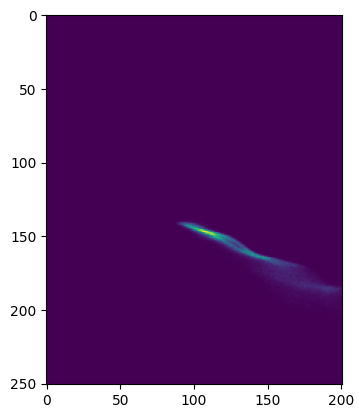

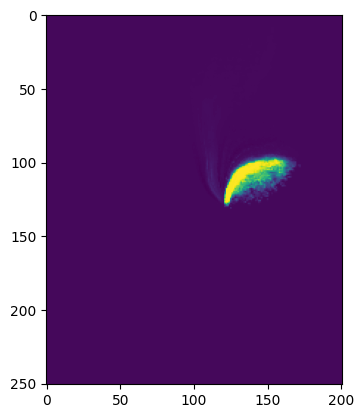

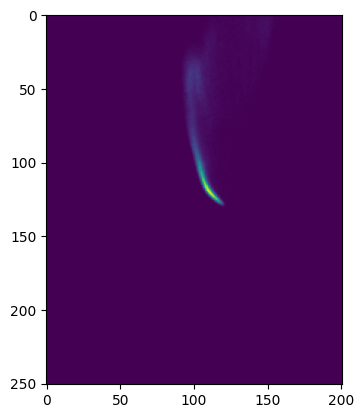

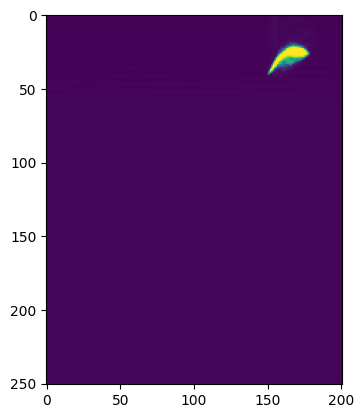

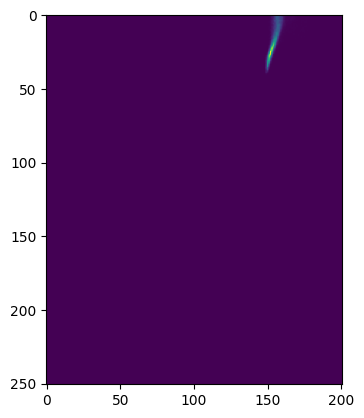

In [73]:
tmodel.eval()
for x, y, coords in test_loader:
    # print(x.shape, y.shape)
    x, y, coords = x.cuda(), y.cuda(), coords.cuda()
    pred = tmodel(x, y[..., 1:])

    # plt.figure()
    plt.imshow(pred[0, ...].reshape((251, 201)).detach().cpu().numpy())
    # plt.show()

    plt.figure()
    plt.imshow(y[0, ..., 0].reshape((251, 201)).detach().cpu().numpy())
    plt.show()

In [70]:
PATH = "transolver_weights_17_to_1.pth"
torch.save(tmodel.state_dict(), PATH)
print(f"Saved weights to {PATH}")

Saved weights to transolver_weights_17_to_1.pth


In [123]:
import torch.nn as nn

class TransolverForSource(nn.Module):
    def __init__(self, transolver_path: str):
        super().__init__()
        # Backbone: учится кодировать 18‑канальное поле
        self.backbone = Model(space_dim=2,
                               n_layers=3,
                               n_hidden=64,
                               n_head=4,
                               Time_Input=False,
                               mlp_ratio=1,
                               fun_dim=17,
                               out_dim=1,
                               slice_num=64,
                               ref=8,
                               unified_pos=1,
                               H=201,
                               W=251).cuda()
        self.backbone.load_state_dict(torch.load(transolver_path))
        # Голова для координат: из скрытого представления (B, C, H, W)
        # → глобальный пулинг → MLP → 2 числа
        self.coord_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),  # (B,C,1,1)
            nn.Flatten(),                 # (B,C)
            nn.Linear(1, 32),            # C = n_hidden
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, coords, fx):
        # coords: (B, N, 2), fx: (B, N, T_in)
        # Получаем выход backbone: (B, N, T_in) и скрытое h: (B, C, H, W)
        # Для этого нужно слегка модифицировать Physics_Attention.py,
        # чтобы он возвращал и h. Предположим, он сейчас возвращает кортеж:
        field_pred = self.backbone(coords, fx)  
        # h: (B, C, H, W) — берём его на вход в голову
        xy = self.coord_head(field_pred.reshape(field_pred.shape[0], 251, 201))  # (B,2)
        return xy

# Instantiate
model = TransolverForSource('/kaggle/working/transolver_weights_17_to_1.pth').cuda()


/tmp/ipykernel_31/2846688320.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.backbone.load_state_dict(torch.load(transolver_path))


In [124]:
for param in model.backbone.parameters():
    param.requires_grad = False

In [126]:
import torch.optim as optim

opt = optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()

for epoch in tqdm(range(100)):
    model.train()
    tot = 0.0
    for x, y, coords in train_loader:
        x, y, coords = x.cuda(), y.cuda(), coords.cuda()
        pred_xy = model(x, y[...,:-1])
        loss = mse(pred_xy, coords[:, [1, 2]].to(torch.float32))

        opt.zero_grad()
        loss.backward()
        opt.step()
        tot += loss.item()
    print(f"Epoch {epoch:02d}  Loss: {tot/len(train_loader):.6f}")

  1%|          | 1/100 [00:12<21:09, 12.82s/it]

Epoch 00  Loss: 4826.037588


  2%|▏         | 2/100 [00:25<21:12, 12.99s/it]

Epoch 01  Loss: 3554.362642


  3%|▎         | 3/100 [00:39<21:08, 13.07s/it]

Epoch 02  Loss: 852.905969


  4%|▍         | 4/100 [00:52<21:04, 13.17s/it]

Epoch 03  Loss: 376.000492


  5%|▌         | 5/100 [01:05<20:53, 13.20s/it]

Epoch 04  Loss: 248.562513


  6%|▌         | 6/100 [01:18<20:39, 13.19s/it]

Epoch 05  Loss: 137.416614


  7%|▋         | 7/100 [01:31<20:25, 13.18s/it]

Epoch 06  Loss: 56.369223


  8%|▊         | 8/100 [01:45<20:12, 13.18s/it]

Epoch 07  Loss: 16.580435


  9%|▉         | 9/100 [01:58<19:59, 13.18s/it]

Epoch 08  Loss: 3.666596


 10%|█         | 10/100 [02:11<19:45, 13.17s/it]

Epoch 09  Loss: 0.999387


 11%|█         | 11/100 [02:24<19:32, 13.17s/it]

Epoch 10  Loss: 0.543589


 12%|█▏        | 12/100 [02:37<19:18, 13.16s/it]

Epoch 11  Loss: 0.416040


 13%|█▎        | 13/100 [02:50<19:05, 13.17s/it]

Epoch 12  Loss: 0.285784


 14%|█▍        | 14/100 [03:04<18:52, 13.17s/it]

Epoch 13  Loss: 0.219533


 15%|█▌        | 15/100 [03:17<18:38, 13.16s/it]

Epoch 14  Loss: 0.173212


 16%|█▌        | 16/100 [03:30<18:25, 13.16s/it]

Epoch 15  Loss: 0.150837


 17%|█▋        | 17/100 [03:43<18:12, 13.16s/it]

Epoch 16  Loss: 0.120554


 18%|█▊        | 18/100 [03:56<17:59, 13.16s/it]

Epoch 17  Loss: 0.102806


 19%|█▉        | 19/100 [04:09<17:46, 13.16s/it]

Epoch 18  Loss: 0.085980


 20%|██        | 20/100 [04:23<17:32, 13.16s/it]

Epoch 19  Loss: 0.074072


 21%|██        | 21/100 [04:36<17:19, 13.16s/it]

Epoch 20  Loss: 0.068099


 22%|██▏       | 22/100 [04:49<17:06, 13.15s/it]

Epoch 21  Loss: 0.060661


 23%|██▎       | 23/100 [05:02<16:53, 13.16s/it]

Epoch 22  Loss: 0.055058


 24%|██▍       | 24/100 [05:15<16:40, 13.17s/it]

Epoch 23  Loss: 0.052171


 25%|██▌       | 25/100 [05:28<16:27, 13.16s/it]

Epoch 24  Loss: 0.046310


 26%|██▌       | 26/100 [05:42<16:14, 13.17s/it]

Epoch 25  Loss: 0.047761


 27%|██▋       | 27/100 [05:55<16:00, 13.16s/it]

Epoch 26  Loss: 0.040955


 28%|██▊       | 28/100 [06:08<15:48, 13.17s/it]

Epoch 27  Loss: 0.038749


 29%|██▉       | 29/100 [06:21<15:34, 13.17s/it]

Epoch 28  Loss: 0.037308


 30%|███       | 30/100 [06:34<15:21, 13.16s/it]

Epoch 29  Loss: 0.035827


 31%|███       | 31/100 [06:47<15:08, 13.16s/it]

Epoch 30  Loss: 0.033642


 32%|███▏      | 32/100 [07:01<14:54, 13.16s/it]

Epoch 31  Loss: 0.032644


 33%|███▎      | 33/100 [07:14<14:41, 13.16s/it]

Epoch 32  Loss: 0.031370


 34%|███▍      | 34/100 [07:27<14:29, 13.17s/it]

Epoch 33  Loss: 0.030877


 35%|███▌      | 35/100 [07:40<14:15, 13.17s/it]

Epoch 34  Loss: 0.030087


 36%|███▌      | 36/100 [07:53<14:02, 13.16s/it]

Epoch 35  Loss: 0.028273


 37%|███▋      | 37/100 [08:06<13:49, 13.16s/it]

Epoch 36  Loss: 0.028420


 38%|███▊      | 38/100 [08:20<13:36, 13.17s/it]

Epoch 37  Loss: 0.026829


 39%|███▉      | 39/100 [08:33<13:23, 13.17s/it]

Epoch 38  Loss: 0.026648


 40%|████      | 40/100 [08:46<13:10, 13.17s/it]

Epoch 39  Loss: 0.025512


 41%|████      | 41/100 [08:59<12:56, 13.17s/it]

Epoch 40  Loss: 0.025947


 42%|████▏     | 42/100 [09:12<12:43, 13.16s/it]

Epoch 41  Loss: 0.024756


 43%|████▎     | 43/100 [09:25<12:30, 13.16s/it]

Epoch 42  Loss: 0.024580


 44%|████▍     | 44/100 [09:39<12:17, 13.17s/it]

Epoch 43  Loss: 0.024607


 45%|████▌     | 45/100 [09:52<12:03, 13.16s/it]

Epoch 44  Loss: 0.024222


 46%|████▌     | 46/100 [10:05<11:50, 13.16s/it]

Epoch 45  Loss: 0.023887


 47%|████▋     | 47/100 [10:18<11:37, 13.16s/it]

Epoch 46  Loss: 0.023885


 48%|████▊     | 48/100 [10:31<11:24, 13.16s/it]

Epoch 47  Loss: 0.023896


 49%|████▉     | 49/100 [10:44<11:11, 13.16s/it]

Epoch 48  Loss: 0.023891


 50%|█████     | 50/100 [10:58<10:58, 13.17s/it]

Epoch 49  Loss: 0.023840


 51%|█████     | 51/100 [11:11<10:44, 13.16s/it]

Epoch 50  Loss: 0.022945


 52%|█████▏    | 52/100 [11:24<10:31, 13.16s/it]

Epoch 51  Loss: 0.023085


 53%|█████▎    | 53/100 [11:37<10:18, 13.16s/it]

Epoch 52  Loss: 0.023651


 54%|█████▍    | 54/100 [11:50<10:05, 13.16s/it]

Epoch 53  Loss: 0.023130


 55%|█████▌    | 55/100 [12:03<09:52, 13.17s/it]

Epoch 54  Loss: 0.022766


 56%|█████▌    | 56/100 [12:16<09:39, 13.16s/it]

Epoch 55  Loss: 0.022439


 57%|█████▋    | 57/100 [12:30<09:26, 13.17s/it]

Epoch 56  Loss: 0.024503


 58%|█████▊    | 58/100 [12:43<09:12, 13.16s/it]

Epoch 57  Loss: 0.022423


 59%|█████▉    | 59/100 [12:56<08:59, 13.17s/it]

Epoch 58  Loss: 0.022547


 60%|██████    | 60/100 [13:09<08:46, 13.17s/it]

Epoch 59  Loss: 0.023471


 61%|██████    | 61/100 [13:22<08:33, 13.16s/it]

Epoch 60  Loss: 0.022218


 62%|██████▏   | 62/100 [13:35<08:20, 13.16s/it]

Epoch 61  Loss: 0.022578


 63%|██████▎   | 63/100 [13:49<08:06, 13.16s/it]

Epoch 62  Loss: 0.022149


 64%|██████▍   | 64/100 [14:02<07:54, 13.17s/it]

Epoch 63  Loss: 0.022577


 65%|██████▌   | 65/100 [14:15<07:40, 13.17s/it]

Epoch 64  Loss: 0.022560


 66%|██████▌   | 66/100 [14:28<07:27, 13.16s/it]

Epoch 65  Loss: 0.024731


 67%|██████▋   | 67/100 [14:41<07:14, 13.17s/it]

Epoch 66  Loss: 0.022870


 68%|██████▊   | 68/100 [14:55<07:01, 13.17s/it]

Epoch 67  Loss: 0.022408


 69%|██████▉   | 69/100 [15:08<06:48, 13.18s/it]

Epoch 68  Loss: 0.023952


 70%|███████   | 70/100 [15:21<06:35, 13.17s/it]

Epoch 69  Loss: 0.022636


 71%|███████   | 71/100 [15:34<06:22, 13.17s/it]

Epoch 70  Loss: 0.022513


 72%|███████▏  | 72/100 [15:47<06:08, 13.17s/it]

Epoch 71  Loss: 0.023727


 73%|███████▎  | 73/100 [16:00<05:55, 13.16s/it]

Epoch 72  Loss: 0.022558


 74%|███████▍  | 74/100 [16:14<05:42, 13.16s/it]

Epoch 73  Loss: 0.022998


 75%|███████▌  | 75/100 [16:27<05:29, 13.17s/it]

Epoch 74  Loss: 0.025617


 76%|███████▌  | 76/100 [16:40<05:16, 13.17s/it]

Epoch 75  Loss: 0.021808


 77%|███████▋  | 77/100 [16:53<05:02, 13.16s/it]

Epoch 76  Loss: 0.022649


 78%|███████▊  | 78/100 [17:06<04:49, 13.16s/it]

Epoch 77  Loss: 0.022831


 79%|███████▉  | 79/100 [17:19<04:36, 13.16s/it]

Epoch 78  Loss: 0.024309


 80%|████████  | 80/100 [17:32<04:23, 13.17s/it]

Epoch 79  Loss: 0.023571


 81%|████████  | 81/100 [17:46<04:10, 13.16s/it]

Epoch 80  Loss: 0.023643


 82%|████████▏ | 82/100 [17:59<03:56, 13.16s/it]

Epoch 81  Loss: 0.022980


 83%|████████▎ | 83/100 [18:12<03:43, 13.16s/it]

Epoch 82  Loss: 0.022751


 84%|████████▍ | 84/100 [18:25<03:30, 13.16s/it]

Epoch 83  Loss: 0.022452


 85%|████████▌ | 85/100 [18:38<03:17, 13.16s/it]

Epoch 84  Loss: 0.022281


 86%|████████▌ | 86/100 [18:51<03:04, 13.17s/it]

Epoch 85  Loss: 0.025377


 87%|████████▋ | 87/100 [19:05<02:51, 13.16s/it]

Epoch 86  Loss: 0.023716


 88%|████████▊ | 88/100 [19:18<02:37, 13.16s/it]

Epoch 87  Loss: 0.023515


 89%|████████▉ | 89/100 [19:31<02:24, 13.16s/it]

Epoch 88  Loss: 0.022840


 90%|█████████ | 90/100 [19:44<02:11, 13.16s/it]

Epoch 89  Loss: 0.022880


 91%|█████████ | 91/100 [19:57<01:58, 13.17s/it]

Epoch 90  Loss: 0.022290


 92%|█████████▏| 92/100 [20:10<01:45, 13.16s/it]

Epoch 91  Loss: 0.023901


 93%|█████████▎| 93/100 [20:24<01:32, 13.16s/it]

Epoch 92  Loss: 0.023190


 94%|█████████▍| 94/100 [20:37<01:18, 13.16s/it]

Epoch 93  Loss: 0.024237


 95%|█████████▌| 95/100 [20:50<01:05, 13.16s/it]

Epoch 94  Loss: 0.022603


 96%|█████████▌| 96/100 [21:03<00:52, 13.16s/it]

Epoch 95  Loss: 0.023363


 97%|█████████▋| 97/100 [21:16<00:39, 13.16s/it]

Epoch 96  Loss: 0.022749


 98%|█████████▊| 98/100 [21:29<00:26, 13.16s/it]

Epoch 97  Loss: 0.022171


 99%|█████████▉| 99/100 [21:43<00:13, 13.16s/it]

Epoch 98  Loss: 0.022805


100%|██████████| 100/100 [21:56<00:00, 13.16s/it]

Epoch 99  Loss: 0.022611


In [130]:
model.eval()

for x, y, coords in test_loader:
    x, y, coords = x.cuda(), y.cuda(), coords.cuda()
    pred_xy = model(x, y[...,:-1])
    print(((coords[:, [1, 2]] - pred_xy)**2).mean())

tensor(0.0122, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.2943, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0055, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0294, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0453, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0577, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0225, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0299, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0275, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0252, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0160, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0051, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


In [131]:
PATH = "model_sources_detection.pth"
torch.save(model.state_dict(), PATH)
print(f"Saved weights to {PATH}")

Saved weights to model_sources_detection.pth


In [ ]:
for ep in range(20):
    tmodel.train()
    train_l2_step = 0
    train_l2_full = 0

    for x, fx, coords in train_loader:
        loss = 0
        x, fx, coords = x.cuda(), fx.cuda(), coords.cuda()
        bsz = x.shape[0]

        for t in range(0, T_in, step):
            y = yy[..., t:t + step]
            print(x.shape, fx.shape)
            im = tmodel(x, fx=fx)
            loss += myloss(im.reshape(bsz, -1), y.reshape(bsz, -1))
            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)
            fx = torch.cat((fx[..., step:], y), dim=-1)

        train_l2_step += loss.item()
        train_l2_full += myloss(pred.reshape(bsz, -1), yy.reshape(bsz, -1)).item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_l2_step = 0
    test_l2_full = 0

    tmodel.eval()

    with torch.no_grad():
        for x, fx, yy, coords in test_loader:
            loss = 0
            x, fx, yy, coords = x.cuda(), fx.cuda(), yy.cuda(), coords.cuda()
            bsz = x.shape[0]
            for t in range(0, T_in, step):
                y = yy[..., t:t + step]
                im = tmodel(x, fx=fx)
                loss += myloss(im.reshape(bsz, -1), y.reshape(bsz, -1))
                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), -1)
                fx = torch.cat((fx[..., step:], im), dim=-1)

            test_l2_step += loss.item()
            test_l2_full += myloss(pred.reshape(bsz, -1), yy.reshape(bsz, -1)).item()

    print(f"Epoch {ep}")
    print(f"train_step_loss = {train_l2_step / ntrain / (T / step):.5f}, train_full_loss = {train_l2_full / ntrain:.5f}")
    print(f"test_step_loss = {test_l2_step / ntest / (T / step):.5f}, test_full_loss = {test_l2_full / ntest:.5f}")

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

tmodel.eval()
showcase = 5
id = 0

with torch.no_grad():
    for x, fx, yy, _ in train_loader:
        id += 1
        x, fx, yy = x.cuda(), fx.cuda(), yy.cuda()  # x : B, 4096, 2  fx : B, 4096  y : B, 4096, T
        bsz = x.shape[0]
        for t in range(0, T, step):
            im = tmodel(x, fx=fx)

            fx = torch.cat((fx[..., step:], im), dim=-1)
            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)

        if id < showcase:
            fig, ax = plt.subplots(ncols=3, figsize=(16, 5))
            plt.title(id)

            ax[0].imshow(im[0, :, -1].reshape(h, h).detach().cpu().numpy())
            ax[0].set_title(f"Sample {id} Prediction")

            ax[1].imshow(yy[0, :, -1].reshape(h, h).detach().cpu().numpy())
            # ax[1].colorbar()
            ax[1].set_title(f"Sample {id} Ground Truth")

            im = ax[2].imshow((im[0, :, -1].reshape(h, h) - yy[0, :, -1].reshape(h, h)).detach().cpu().numpy())
            # ax[2].colorbar()
            ax[2].set_title(f"Sample {id} Error")
            divider = make_axes_locatable(ax[2])
            cax = divider.append_axes('right', size='10%', pad=0.1)
            fig.colorbar(im, cax=cax, orientation='vertical')

            plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

tmodel.eval()
showcase = 5
id = 0

with torch.no_grad():
    for x, fx, yy, _ in test_loader:
        id += 1
        x, fx, yy = x.cuda(), fx.cuda(), yy.cuda()  # x : B, 4096, 2  fx : B, 4096  y : B, 4096, T
        bsz = x.shape[0]
        for t in range(0, T, step):
            im = tmodel(x, fx=fx)

            fx = torch.cat((fx[..., step:], im), dim=-1)
            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)

        if id < showcase:
            fig, ax = plt.subplots(ncols=3, figsize=(16, 5))
            plt.title(id)

            ax[0].imshow(im[0, :, 0].reshape(h, h).detach().cpu().numpy())
            ax[0].set_title(f"Sample {id} Prediction")

            ax[1].imshow(yy[0, :, 0].reshape(h, h).detach().cpu().numpy())
            # ax[1].colorbar()
            ax[1].set_title(f"Sample {id} Ground Truth")

            im = ax[2].imshow((im[0, :, 0].reshape(h, h) - yy[0, :, 0].reshape(h, h)).detach().cpu().numpy())
            # ax[2].colorbar()
            ax[2].set_title(f"Sample {id} Error")
            divider = make_axes_locatable(ax[2])
            cax = divider.append_axes('right', size='10%', pad=0.1)
            fig.colorbar(im, cax=cax, orientation='vertical')

            plt.show()

In [ ]:
# train knn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import top_k_accuracy_score

In [ ]:
tmodel.eval()
id = 0
preds_start_point = np.zeros((150, h, h))
sources = np.zeros((150, 5))
with torch.no_grad():
    for x, fx, yy, coords in train_loader:
        id += 1
        x, fx, yy = x.cuda(), fx.cuda(), yy.cuda()  # x : B, 4096, 2  fx : B, 4096  y : B, 4096, T
        bsz = x.shape[0]
        for t in range(0, T, step):
            im = tmodel(x, fx=fx)

            fx = torch.cat((fx[..., step:], im), dim=-1)
            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)
        if id == 19:
            preds_start_point[8 * id - 8:  , :, :] = pred[:, :, -1].reshape(x.shape[0], h, h).detach().cpu().numpy()
            sources[8 * id - 8: , :] = coords[0, :].detach().cpu().numpy()
        else:
            preds_start_point[8 * id - 8: 8 * id, :, :] = pred[:, :, -1].reshape(x.shape[0], h, h).detach().cpu().numpy()
            sources[8 * id - 8: 8 * id, :] = coords[0, :].detach().cpu().numpy()

In [ ]:
sources[:, 0]

In [ ]:
clf = KNeighborsClassifier(n_neighbors=3)
X_train_flat = preds_start_point.reshape(preds_start_point.shape[0], -1)
clf.fit(X_train_flat, sources[:, 0])

In [ ]:
# clf = XGBClassifier(max_depth=2, n_estimators=3)
# X_train_flat = preds_start_point.reshape(preds_start_point.shape[0], -1)
# clf.fit(X_train_flat, sources[:, 0])

In [ ]:
train_pred_source = clf.predict_proba(X_train_flat)
# np.mean(train_pred_source == sources[:, 0])
top_k_accuracy_score(sources[:, 0], train_pred_source, k=3)

In [ ]:
tmodel.eval()
id = 0
preds_start_point = np.zeros((50, h, h))
sources = np.zeros((50, 5))
with torch.no_grad():
    for x, fx, yy, coords in test_loader:
        id += 1
        x, fx, yy = x.cuda(), fx.cuda(), yy.cuda()  # x : B, 4096, 2  fx : B, 4096  y : B, 4096, T
        bsz = x.shape[0]
        for t in range(0, T, step):
            im = tmodel(x, fx=fx)

            fx = torch.cat((fx[..., step:], im), dim=-1)
            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)
        if id == 7:
            preds_start_point[8 * id - 8:  , :, :] = pred[:, :, -1].reshape(x.shape[0], h, h).detach().cpu().numpy()
            sources[8 * id - 8: , :] = coords[0, :].detach().cpu().numpy()
        else:
            preds_start_point[8 * id - 8: 8 * id, :, :] = pred[:, :, -1].reshape(x.shape[0], h, h).detach().cpu().numpy()
            sources[8 * id - 8: 8 * id, :] = coords[0, :].detach().cpu().numpy()

In [ ]:
def top_k_cust(y_true, y_pred):
  true_res = 0
  for i, y in enumerate(y_true):
    if y in y_pred[i]:
      true_res += 1
  return true_res / y_true.shape[0]

In [ ]:
X_test_flat = preds_start_point.reshape(preds_start_point.shape[0], -1)
test_pred_source = clf.predict_proba(X_test_flat)
top_k_indices = np.argsort(test_pred_source, axis=1)[:, -3:]
top_k_cust(sources[:, 0], top_k_indices)

In [ ]:
top_k_indices

In [ ]:
test_pred_source

In [ ]:
np.unique(sources[:, 0])

In [ ]:
test_pred_source.shape

In [ ]:
sources[:, 0]

In [ ]:
test_pred_source

In [ ]:
import torch
import timm
from torchvision import transforms

class ViTImageClassifier:
    def __init__(self, num_classes=10, model_name='vit_base_patch16_224', pretrained=True):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_classes = num_classes

        self.model = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=num_classes
        )
        self.model = self.model.to(self.device)
        self.model.eval()


    def predict(self, image_path):

        input_tensor = self.preprocess_image(image_path).to(self.device)

        with torch.no_grad():
            outputs = self.model(input_tensor)

        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        return torch.argmax(probabilities).item(), probabilities.cpu().numpy()